# Using Deep Learning to Detect Type of Bee

<p><img src="https://assets.datacamp.com/production/project_555/img/92_notebook.jpg" alt="honey bee">
<em>Honey Bee (Apis).</em></p>
<p>Honey bee and bumble bee have distinct apperance and characteristic.
<p><img src="https://assets.datacamp.com/production/project_555/img/20_notebook.jpg" alt="bumble bee">
<em>Bumble bee (Bombus).</em></p>
<p>In this notebook, we'll create a simple deep learning model that can predict type of bee by using pre-trained model to evaluate.</p>

In [1]:
import pickle
from pathlib import Path
from skimage import io

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
# a magic function
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

## Load dataset

In [2]:
# load labels.csv from datasets folder using pandas
labels = pd.read_csv(r'S:\L2S\CODE\bee_prediction\datasets\labels.csv', index_col=0)

# print value counts for genus
print(labels.genus.value_counts())

# assign the genus label values to y
y = labels.genus.values

genus
1.0    827
0.0    827
Name: count, dtype: int64


In [3]:
# data precheck
labels.info()
labels.genus.unique()

<class 'pandas.core.frame.DataFrame'>
Index: 1654 entries, 520 to 2636
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   genus   1654 non-null   float64
dtypes: float64(1)
memory usage: 25.8 KB


array([1., 0.])

# Analysis RGB value on the represented matrix

Image has shape: (200, 200, 3)
RGB values for the top left pixel are: [129 109 100]


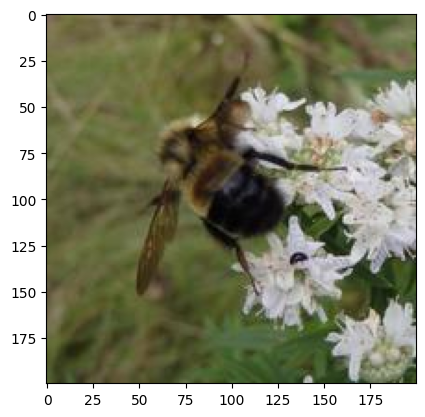

In [4]:
# load an image and explore
example_image = io.imread('../images/{}.jpg'.format(labels.index[0]))

# show image
plt.imshow(example_image) 

# print shape
print('Image has shape:', example_image.shape)

# print color channel values for top left pixel
print('RGB values for the top left pixel are:', example_image[0, 0, :])

# Normalization through values on the matrix

In [5]:
# initialize standard scaler
ss = StandardScaler()

image_list = []
X = np.array([])
for i in labels.index:
    # load image
    img = io.imread(r'S:\L2S\CODE\bee_prediction\images\{}.jpg'.format(i)).astype(np.float64)
    
    # for each channel, apply standard scaler's fit_transform method
    for channel in range(img.shape[2]):
        img[:, :, channel] = ss.fit_transform(img[:, :, channel])
        
    # append to list of all images
    if img.shape == (200, 200, 3):
        image_list.append(img)
    else:
        drop = i


In [6]:
X = np.array(image_list) # convert to an array format
print(X.shape)

(1653, 200, 200, 3)


In [7]:
drop

1974

In [8]:
labels.loc[drop].name

1974

In [9]:
clean_df = labels.drop(labels.loc[1974].name)

In [10]:
# print value counts for genus
print(clean_df.value_counts())

# assign the genus label values to y
y = clean_df.values # subset genus and get the values

genus
1.0      827
0.0      826
Name: count, dtype: int64


# Split the data into train, test, and evaluation sets

In [11]:
# split out evaluation sets (x_eval and y_eval)
x_interim, x_eval, y_interim, y_eval = train_test_split(X, y, test_size=0.2, random_state=52)

# split remaining data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_interim, y_interim, test_size=0.4, random_state=52)

# examine number of samples in train, test, and validation sets
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_eval.shape[0], 'eval samples')

x_train shape: (793, 200, 200, 3)
793 train samples
529 test samples
331 eval samples


# Creating the 1st Model

We'll create a deep learning model using Convolutional Neural Network (CNN). CNN is one of the Deep Learning models that is very effective in classifying images. We'll be using TensorFlow 2.0 to make a Sequential model, where we can make a linear stack of layers.

To understand CNN, imageine if there is a flashlight hightlighting the images from the top left corner to the bottom right corner, exploring one pixel to another, like how we read a text from left to right-bottom of the page. Convolutional layer uses a kernel called "sliding window" against pictures and performs element-wise matrix multiplication between kernel values and pixel values from images.

In [12]:
# set model constants
num_classes = 1 # to predict those which have 0-1 scale

# define model as Sequential
model = Sequential()

# first convolutional layer with 32 filters
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(200, 200, 3)))

# add a second 2D convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

C:\Users\Pongo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Creating the 2nd Model

<p>by far we've got 2 convolutional layers. However, there are several other ones necessary to make the deep learning model better. Researches in the deep learning nowadays, more directed at how to arrange a structure from an array of layers to be an appropriate system to predict.

<p>We're going to add the following layers:</p>
<ul>
<li><a href="https://keras.io/layers/pooling/#maxpooling2d"><code>MaxPooling</code></a>. Max Pooling will provide a moving window possessing a dimension (2, 2) on images and will downscales size from images by taking the maximum value.</li>
<li><a href="https://keras.io/layers/convolutional/#conv2d"><code>Conv2D</code></a>. We can add Convolutional Layers, then this is the 3rd Convolutional layer to deepen the Deep Learning model. By adding more Convolutional layer, the model will get better in learning features in the images.</li>
<li><a href="https://keras.io/layers/core/#dropout"><code>Dropout</code></a>. Drouput layer will deactivate several neron units randomly on each layer. This technique is able to prevent overfitting model, by means of preventing a centralised learning at merely some neuron units, while other neuron units are not learning appropriately.</li>
<li><a href="https://keras.io/layers/core/#flatten"><code>Flatten</code></a>. Flatten layer is an output layer from convolutional layer. Usually once calling Flatten, subsequently it can be linked with fully connected layers.</li>
<li><a href="https://keras.io/layers/core/#dense"><code>Dense</code></a>. Fully connected layer where each input will be connected with every output (please see the following image).</li>
<li><a href="https://keras.io/layers/core/#dropout"><code>Dropout</code></a>. Other dropout layers to ensure the models are not overfitting, at this moment with 50% rate.</li>
<li><code>Dense</code>. Final layer will perform calculation of probability value between Apis and Bombus.</li>
</ul>
<p> To see all layers that have been stacked, we can see it from model summary. We may pay attention that the mode has <code>75,554,049</code> paramaters. This is the value of the model made, and will be updated during training processes. This value will be used to generate a prediction towards new images.</p>
<p><img src="https://assets.datacamp.com/production/project_555/img/mlp_conv.png" alt></p>

In [13]:
# reduce dimensionality through max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

# third convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

# add dropout to prevent over fitting
model.add(Dropout(0.25))

# necessary flatten step preceeding dense layer
model.add(Flatten())

# fully connected layer
model.add(Dense(128, activation='relu'))

# add additional dropout to prevent overfitting
model.add(Dropout(0.5))

# prediction layers
model.add(Dense(num_classes, activation='sigmoid', name='preds'))

# show model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 196, 196, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 98, 98, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 96, 96, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96, 96, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 589824)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    75,497,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preds (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,554,049 (288.22 MB)

 Trainable params: 75,554,049 (288.22 MB)

 Non-trainable params: 0 (0.00 B)

# Compile and Train Model

In [14]:
model.compile(
    # set the loss as binary_crossentropy
    loss=tf.keras.losses.binary_crossentropy,

    # set the optimizer as stochastic gradient descent
    optimizer='adam',

    # set the metric as accuracy
    metrics=['accuracy']
)

# mock-train the model using the first ten observations of the train and test sets
hist = model.fit(x_train[:100, :, :, :],
                 y_train[:100],
    epochs=20,
    verbose=1,
    validation_data=(x_test[:100, :, :, :], y_test[:100])
)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.4694 - loss: 35.1819 - val_accuracy: 0.4600 - val_loss: 7.8308
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.5890 - loss: 3.4258 - val_accuracy: 0.5400 - val_loss: 1.2420
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.4985 - loss: 1.0502 - val_accuracy: 0.4500 - val_loss: 0.7010
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.7465 - loss: 0.5965 - val_accuracy: 0.4800 - val_loss: 0.7019
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 921ms/step - accuracy: 0.7314 - loss: 0.4897 - val_accuracy: 0.5700 - val_loss: 0.7264
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.8092 - loss: 0.3751 - val_accuracy: 0.5400 - val_loss: 0.6802
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.9785 - loss: 0.2035 - val_accuracy: 0.6200 - val_loss: 0.6650
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.9693 - loss: 0.1014 - val_accuracy: 0.6100 - val_loss: 0.7325
Epoch

In [15]:
model.save('../models/bee_prediction.h5') # save('models/DTSense_model_nama.h5')

# Load pre-trained model and score

In [16]:
# load pre-trained model
pretrained_cnn = tf.keras.models.load_model("../models/bee_prediction.h5")

# evaluate model on test set
score = pretrained_cnn.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("")

Test loss: 1.2767915725708008
Test accuracy: 0.5652173757553101



Eval loss: 1.3542757034301758
Eval accuracy: 0.5830815434455872


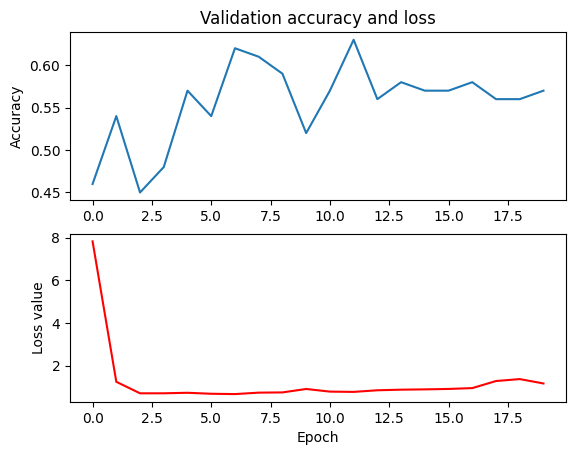

In [17]:
# evaluate model on holdout set
eval_score = pretrained_cnn.evaluate(x_eval, y_eval, verbose=0)

# print loss score
print('Eval loss:', eval_score[0])

# print accuracy score
print('Eval accuracy:', eval_score[1])
pretrained_cnn_history = hist
# print keys for pretrained_cnn_history dict
# print(pretrained_cnn_history.keys())

fig = plt.figure(1)
plt.subplot(211)
# plot the validation accuracy
plt.plot(pretrained_cnn_history.history['val_accuracy'])
plt.title('Validation accuracy and loss')
plt.ylabel('Accuracy')
plt.subplot(212)
# plot the validation loss
plt.plot(pretrained_cnn_history.history['val_loss'], 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss value');


In [18]:
# predicted probabilities for x_eval
y_proba = pretrained_cnn.predict(x_eval)

print("First five probabilities:")
print(y_proba[:5])
print("")

# predicted classes for x_eval
y_pred = np.round(y_proba).astype('int')

print("First five class predictions:")
print(y_pred[:5])
print("")


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step
First five probabilities:
[[4.3320030e-04]
 [3.6857224e-01]
 [9.8700500e-01]
 [4.6079755e-02]
 [5.9077990e-01]]

First five class predictions:
[[0]
 [0]
 [1]
 [0]
 [1]]

